# Import

In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(),".."))

import copy
import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pytransform3d
import pytransform3d.camera as pc
import pytransform3d.rotations as pr
import pytransform3d.transformations as pt
from pytransform3d.urdf import UrdfTransformManager
from pytransform3d.plot_utils import make_3d_axis, plot_vector
from urdf_parser_py.urdf import URDF

import math
import json
import itertools
from scipy.optimize import minimize, least_squares

import cv2.aruco as aruco

# Helper Functions

In [2]:
%matplotlib widget

def load_json(filename: str):
    # Construct the absolute path by joining the current directory and relative path
    absolute_path = os.path.join(os.getcwd(), '..', filename)
    # Load the JSON data
    with open(absolute_path, 'r') as file:
        json_data = json.load(file)    
    return json_data

def xml_to_str(robot):
    # To XML string with filtering
    temp_str = robot.to_xml_string()
    words = temp_str.split()
    words[5] = '>'
    urdf_str = ' '.join(words)
    return urdf_str

class ExpChArucoAttention(object):

    def __init__(self, square_length=0.136, marker_length=0.091) -> None:
        self.chess_squares = (15, 8)
        self.square_length = square_length  # [Sweep] 19.4 cm, [Eval] 9.557 cm
        self.marker_length = marker_length  # [Sweep] 15 cm, [Eval] 7.436 cm        
        self.dictionary = aruco.getPredefinedDictionary(aruco.DICT_4X4_100)
        self.parameters = aruco.DetectorParameters()
        self.parameters.cornerRefinementMethod = aruco.CORNER_REFINE_SUBPIX
        self.board = aruco.CharucoBoard(self.chess_squares, self.square_length, self.marker_length, self.dictionary)
        self.criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

        self.charuco_detector = aruco.CharucoDetector(self.board)

# Initialization

In [3]:
# Load Configs
cam_mtxs = load_json('camera_mtx.json')
gaze_ctrs = load_json('calib_params.json')
urdf_path = os.path.join(os.getcwd(),"..","urdf","chest_grace_cam_true.urdf")
robot = URDF.from_xml_file(urdf_path)

# Load CSV Optimization Results
fit_result = "20241010_024613_791140_500_075m_grace_results.csv"
data_dir = "thesis"
csv_path = os.path.join(os.getcwd(),"..","results",data_dir,fit_result)
csv_df = pd.read_csv(csv_path, index_col=0)
var_dict = dict(zip(csv_df.index,csv_df['learned'].values))

# Decision Variables 
var_list = list(var_dict.values())

# Variable Names
var_names_list = list(var_dict.keys())

# Mapping
idx2var = dict(zip(list(range(len(var_names_list))),var_names_list))
var2idx = dict(zip(var_names_list, list(range(len(var_names_list)))))

# Variable Assignment
V = np.array(var_list)

# URDF Variable Assignment
for joint in robot.joints:
    if joint.name == 'torso':
        joint.origin.position[0] = V[var2idx['torso_origin_x']]
        joint.origin.position[1] = V[var2idx['torso_origin_y']]
        joint.origin.position[2] = V[var2idx['torso_origin_z']]
    elif joint.name == 'neck_pitch':
        joint.origin.rotation[0] = V[var2idx['neck_pitch_rot_r']]
    elif joint.name == 'head_pitch':
        joint.origin.position[2] = V[var2idx['head_pitch_origin_z']]
    elif joint.name == 'eyes_pitch':
        joint.origin.position[0] = V[var2idx['eyes_pitch_origin_x']]
        joint.origin.position[2] = V[var2idx['eyes_pitch_origin_z']]
    elif joint.name == 'lefteye_yaw':
        joint.origin.position[1] = V[var2idx['lefteye_yaw_origin_y']]
    elif joint.name == 'righteye_yaw':
        joint.origin.position[1] = -V[var2idx['lefteye_yaw_origin_y']]
    elif joint.name == 'lefteye_cam':
        joint.origin.position[0] = V[var2idx['lefteye_cam_origin_x']]
        joint.origin.rotation[0] = V[var2idx['lefteye_cam_rot_r']]
        joint.origin.rotation[2] = V[var2idx['lefteye_cam_rot_y']]
    elif joint.name == 'righteye_cam':
        joint.origin.position[0] = V[var2idx['righteye_cam_origin_x']]
        joint.origin.rotation[0] = V[var2idx['righteye_cam_rot_r']]
        joint.origin.rotation[2] = V[var2idx['righteye_cam_rot_y']]
        
# XML to String
urdf_str = xml_to_str(robot)

# Transform Manager
tm = UrdfTransformManager()
tm.load_urdf(urdf_str)

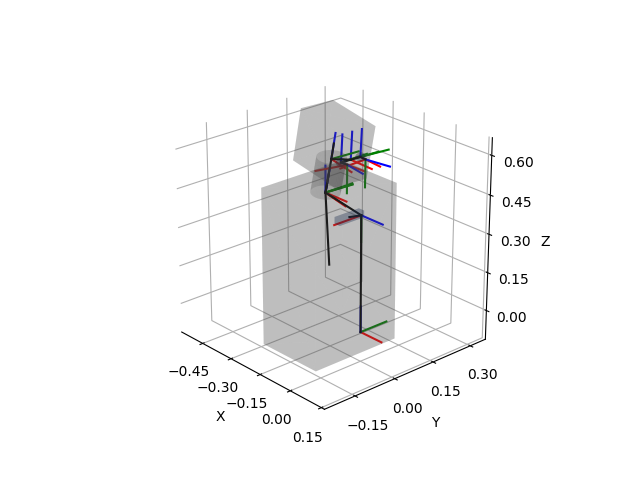

In [4]:
# Input (rad)

cmd_lnt = math.radians(0)
cmd_lnp = math.radians(0)
cmd_unt = math.radians(0)
cmd_et = math.radians(0)
cmd_lep = math.radians(0)
cmd_rep = math.radians(0)

# Motor-to-Joint Mapping
neck_pitch = V[var2idx['neck_pitch_polyfit_b0']] + cmd_lnt * V[var2idx['neck_pitch_polyfit_b1']]
neck_yaw = V[var2idx['neck_yaw_polyfit_b0']] + cmd_lnp * V[var2idx['neck_yaw_polyfit_b1']]
head_pitch = V[var2idx['head_pitch_polyfit_b0']] + cmd_unt * V[var2idx['head_pitch_polyfit_b1']]
eyes_pitch = V[var2idx['eyes_pitch_polyfit_b0']] + cmd_et * V[var2idx['eyes_pitch_polyfit_b1']]
lefteye_yaw = V[var2idx['lefteye_yaw_polyfit_b0']] + cmd_lep * V[var2idx['lefteye_yaw_polyfit_b1']]
righteye_yaw = V[var2idx['righteye_yaw_polyfit_b0']] + cmd_rep * V[var2idx['righteye_yaw_polyfit_b1']]

# Setting Motor Joints
tm.set_joint('neck_pitch', neck_pitch)
tm.set_joint('neck_yaw', neck_yaw)
tm.set_joint('head_pitch', head_pitch)
tm.set_joint('eyes_pitch', eyes_pitch)
tm.set_joint('lefteye_yaw', lefteye_yaw)
tm.set_joint('righteye_yaw', righteye_yaw)

# Visualize
plt.figure()
ax = make_3d_axis(1, 111, unit="m")
joints_list = ["world","torso","realsense","neck","neck_py","head","eyes","lefteye","righteye","leftcamera","rightcamera"]
ax = tm.plot_frames_in("world", whitelist=joints_list,
                       s=0.1, show_name=False, ax=ax)
ax = tm.plot_connections_in("world", ax=ax)
ax = tm.plot_visuals("world", alpha=0.2)
ax.set_xlim([-0.55, 0.15])
ax.set_ylim([-0.25, 0.35])
ax.set_zlim([-0.1, 0.65])
ax.view_init(elev=24, azim=-42, roll=0)
plt.show()

# Load CSV

In [5]:
data_folder = 'debug_20241011_213114_141445_1m_500'
data_dir = 'target_exp'
files_path = os.path.join(os.getcwd(),"..",'data', data_dir, data_folder, f"*.csv")
csv_files = glob.glob(files_path)

In [6]:
dfs = []
for csv_file in csv_files:
    temp_df = pd.read_csv(csv_file)
    dfs.append(temp_df)

df = pd.concat(dfs, ignore_index=True)
print(df.shape)
df

(9, 54)


,charuco_id,u_c_t,v_c_t,x_c_t,y_c_t,z_c_t,u_g_l,v_g_l,u_g_r,v_g_r,...,state_theta_right_eye_pan,state_theta_eyes_tilt,err_u_l,err_v_l,err_u_r,err_v_r,err_x_b_l,err_y_b_l,err_x_b_r,err_y_b_r
0,48,365.15020,137.73094,-0.100113,-0.171213,0.983365,400.721505,238.436491,139.546724,252.199447,...,3.164062,13.183594,-8.953439,1.122576,-6.305314,0.400086,0.013328,-0.001291,0.009426,-0.000014
1,49,447.48062,136.65220,0.035678,-0.174221,0.989888,400.721505,238.436491,139.546724,252.199447,...,8.085938,14.062500,-500.721505,-338.436491,-7.904725,-0.800078,-101.088000,-100.544000,0.011765,0.002099
2,50,528.98980,135.28499,0.171493,-0.177252,0.996341,400.721505,238.436491,139.546724,252.199447,...,12.744141,14.941406,-8.584603,-2.956251,-3.811845,-2.375106,0.013702,0.005528,0.006003,0.004210
3,62,366.76773,220.13010,-0.096980,-0.035291,0.980307,400.721505,238.436491,139.546724,252.199447,...,3.339844,-7.558594,-5.383309,3.926073,-4.308076,3.010972,0.007971,-0.006193,0.006398,-0.004313
4,63,449.46870,218.59116,0.038871,-0.038298,0.986759,400.721505,238.436491,139.546724,252.199447,...,8.261719,-6.943359,-8.954446,2.946062,-4.480256,3.615266,0.014005,-0.004589,0.006757,-0.004905
5,64,530.99884,216.95055,0.174697,-0.041330,0.993273,400.721505,238.436491,139.546724,252.199447,...,13.095703,-6.503906,-4.102578,2.436937,-9.826967,3.482408,0.006519,-0.003872,0.015366,-0.004882
6,76,368.51147,303.21500,-0.093746,0.100643,0.977195,400.721505,238.436491,139.546724,252.199447,...,3.779297,-27.333984,-6.358499,-3.421385,-10.818849,-4.602874,0.009765,0.006398,0.016275,0.008492
7,77,451.50058,301.01385,0.042040,0.097616,0.983687,400.721505,238.436491,139.546724,252.199447,...,8.173828,-27.246094,-10.766427,-4.483015,-3.551317,-4.956023,0.018178,0.008394,0.005892,0.009110
8,78,533.11865,298.79010,0.177856,0.094587,0.990197,400.721505,238.436491,139.546724,252.199447,...,12.744141,-27.070312,-5.955178,-4.777586,-2.021013,-4.637237,0.010512,0.008723,0.004007,0.008303


In [7]:
# Filtered df
temp_df = df[~df.isin([-100.0]).any(axis=1)]
valid_df = temp_df[~temp_df.isin([-180.17578125]).any(axis=1)]
valid_df = valid_df.reset_index(drop=True)
print('Valid:',len(valid_df))
print('Removed:', len(df)-len(valid_df))
valid_df.head()

Valid: 8
Removed: 1


,charuco_id,u_c_t,v_c_t,x_c_t,y_c_t,z_c_t,u_g_l,v_g_l,u_g_r,v_g_r,...,state_theta_right_eye_pan,state_theta_eyes_tilt,err_u_l,err_v_l,err_u_r,err_v_r,err_x_b_l,err_y_b_l,err_x_b_r,err_y_b_r
0,48,365.15020,137.73094,-0.100113,-0.171213,0.983365,400.721505,238.436491,139.546724,252.199447,...,3.164062,13.183594,-8.953439,1.122576,-6.305314,0.400086,0.013328,-0.001291,0.009426,-0.000014
1,50,528.98980,135.28499,0.171493,-0.177252,0.996341,400.721505,238.436491,139.546724,252.199447,...,12.744141,14.941406,-8.584603,-2.956251,-3.811845,-2.375106,0.013702,0.005528,0.006003,0.004210
2,62,366.76773,220.13010,-0.096980,-0.035291,0.980307,400.721505,238.436491,139.546724,252.199447,...,3.339844,-7.558594,-5.383309,3.926073,-4.308076,3.010972,0.007971,-0.006193,0.006398,-0.004313
3,63,449.46870,218.59116,0.038871,-0.038298,0.986759,400.721505,238.436491,139.546724,252.199447,...,8.261719,-6.943359,-8.954446,2.946062,-4.480256,3.615266,0.014005,-0.004589,0.006757,-0.004905
4,64,530.99884,216.95055,0.174697,-0.041330,0.993273,400.721505,238.436491,139.546724,252.199447,...,13.095703,-6.503906,-4.102578,2.436937,-9.826967,3.482408,0.006519,-0.003872,0.015366,-0.004882


# Pose Analysis

In [8]:
i=0

# Input (rad)
cmd_lnt = math.radians(valid_df['cmd_theta_lower_neck_pan'][i])
cmd_lnp = math.radians(valid_df['cmd_theta_lower_neck_tilt'][i])
cmd_unt = math.radians(valid_df['cmd_theta_upper_neck_tilt'][i])
cmd_et = math.radians(valid_df['cmd_theta_left_eye_pan'][i])
cmd_lep = math.radians(valid_df['cmd_theta_right_eye_pan'][i])
cmd_rep = math.radians(valid_df['cmd_theta_eyes_tilt'][i])

# Motor-to-Joint Mapping
neck_pitch = V[var2idx['neck_pitch_polyfit_b0']] + cmd_lnt * V[var2idx['neck_pitch_polyfit_b1']]
neck_yaw = V[var2idx['neck_yaw_polyfit_b0']] + cmd_lnp * V[var2idx['neck_yaw_polyfit_b1']]
head_pitch = V[var2idx['head_pitch_polyfit_b0']] + cmd_unt * V[var2idx['head_pitch_polyfit_b1']]
eyes_pitch = V[var2idx['eyes_pitch_polyfit_b0']] + cmd_et * V[var2idx['eyes_pitch_polyfit_b1']]
lefteye_yaw = V[var2idx['lefteye_yaw_polyfit_b0']] + cmd_lep * V[var2idx['lefteye_yaw_polyfit_b1']]
righteye_yaw = V[var2idx['righteye_yaw_polyfit_b0']] + cmd_rep * V[var2idx['righteye_yaw_polyfit_b1']]

# Setting Motor Joints
tm.set_joint('neck_pitch', neck_pitch)
tm.set_joint('neck_yaw', neck_yaw)
tm.set_joint('head_pitch', head_pitch)
tm.set_joint('eyes_pitch', eyes_pitch)
tm.set_joint('lefteye_yaw', lefteye_yaw)
tm.set_joint('righteye_yaw', righteye_yaw)

# Get Transform
T_clprime = tm.get_transform('realsense','leftcamera')   # Opencv coords
T_crprime = tm.get_transform('realsense','rightcamera')   # Opencv coords
T_lprimec = tm.get_transform('leftcamera','realsense')
T_rprimec = tm.get_transform('rightcamera','realsense')

# Get Rvec and Tvec
model_l_rvec,_ = cv2.Rodrigues(T_clprime[:3,:3])
model_l_tvec = T_clprime[:3,3].flatten()
model_r_rvec,_ = cv2.Rodrigues(T_crprime[:3,:3])
model_r_tvec = T_crprime[:3,3].flatten()
print('model_l_rvec:', model_l_rvec.flatten())
print('model_l_tvec:', model_l_tvec)
print('model_r_rvec:', model_r_rvec.flatten())
print('model_r_tvec:', model_r_tvec)

print('-------')

# Actual
actual_l_rvec = np.array([valid_df['l_rvec_0'][i],valid_df['l_rvec_1'][i],valid_df['l_rvec_2'][i]])
actual_l_tvec = np.array([valid_df['l_tvec_0'][i],valid_df['l_tvec_1'][i],valid_df['l_tvec_2'][i]])
actual_l_rmat,_ = cv2.Rodrigues(actual_l_rvec)
actual_T_clprime = np.eye(4)
actual_T_clprime[:3,:3] = actual_l_rmat.squeeze()
actual_T_clprime[:3,3] = actual_l_tvec 
actual_T_lprimec = np.linalg.inv(actual_T_clprime)

actual_r_rvec = np.array([valid_df['r_rvec_0'][i],valid_df['r_rvec_1'][i],valid_df['r_rvec_2'][i]])
actual_r_tvec = np.array([valid_df['r_tvec_0'][i],valid_df['r_tvec_1'][i],valid_df['r_tvec_2'][i]])
actual_r_rmat,_ = cv2.Rodrigues(actual_r_rvec)
actual_T_crprime = np.eye(4)
actual_T_crprime[:3,:3] = actual_r_rmat.squeeze()
actual_T_crprime[:3,3] = actual_r_tvec 
actual_T_rprimec = np.linalg.inv(actual_T_crprime)

print('actual_l_rvec:', actual_l_rvec)
print('actual_l_tvec:', actual_l_tvec)
print('actual_r_rvec:', actual_r_rvec)
print('actual_r_tvec:', actual_r_tvec)

model_l_rvec: [-0.19900347 -0.28994111  0.0918347 ]
model_l_tvec: [-0.04815188  0.22278002 -0.05994136]
model_r_rvec: [-0.243928   -0.88024633  0.06622797]
model_r_tvec: [-0.07434692  0.21736701 -0.12298246]
-------
actual_l_rvec: [-0.01326517  0.23784405 -0.03205303]
actual_l_tvec: [ 0.01987389  0.19864989 -0.04360802]
actual_r_rvec: [-0.03780049 -0.12169874 -0.0084407 ]
actual_r_tvec: [-0.04300662  0.1934926  -0.06167736]


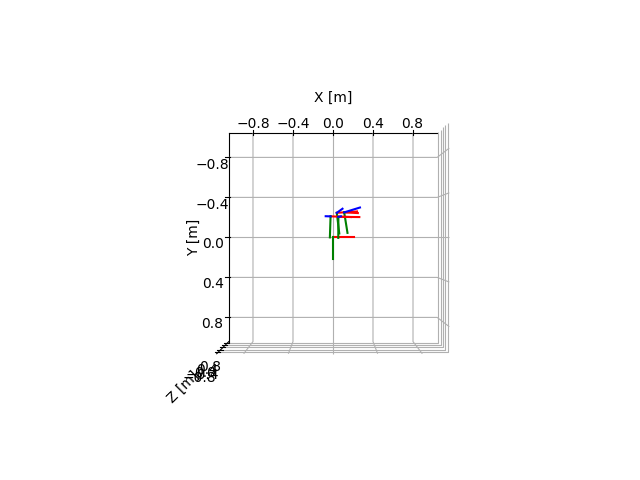

In [18]:
# Visualize
plt.figure()
ax = make_3d_axis(1, 111, unit="m")
ax = pr.plot_basis(ax, s=0.2)
ax = pr.plot_basis(ax, T_lprimec[:3,:3], T_lprimec[:3,3], s=0.2)
ax = pr.plot_basis(ax, T_rprimec[:3,:3], T_rprimec[:3,3], s=0.2)
ax = pr.plot_basis(ax, actual_T_lprimec[:3,:3], actual_T_lprimec[:3,3], s=0.2)
ax = pr.plot_basis(ax, actual_T_rprimec[:3,:3], actual_T_rprimec[:3,3], s=0.2)
ax.view_init(elev=-90, azim=-90)

In [14]:
actual_T_lr = np.linalg.inv(actual_T_clprime) @ actual_T_crprime
actual_T_lr

array([[ 0.9357245 , -0.01413115, -0.35244854, -0.05665392],
       [ 0.02177641,  0.99960553,  0.01773632, -0.0067457 ],
       [ 0.35205887, -0.02427137,  0.93566311, -0.03243279],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [16]:
print("cmd_lnt:", valid_df['cmd_theta_lower_neck_pan'][i])
print("cmd_lnp:", valid_df['cmd_theta_lower_neck_tilt'][i])
print("cmd_unt:", valid_df['cmd_theta_upper_neck_tilt'][i])
print("cmd_et:", valid_df['cmd_theta_left_eye_pan'][i])
print("cmd_lep:", valid_df['cmd_theta_right_eye_pan'][i])
print("cmd_rep:", valid_df['cmd_theta_eyes_tilt'][i])


cmd_lnt: -13
cmd_lnp: 20
cmd_unt: 6
cmd_et: 1.411575267229328
cmd_lep: 3.4175745375815465
cmd_rep: 13.059274082653666


# Loading Image

In [ ]:
data_folder = 'debug_20241011_182737_446179_1m_500'
data_dir = 'target_exp'
img_path = os.path.join(os.getcwd(),"..",'data', data_dir, data_folder, "img",f"*.png")
img_files = glob.glob(img_path)

In [ ]:
img_list = []
for x in img_files:
    img = cv2.imread(x)
    img_list.append(img)
    plt.figure()
    plt.imshow(img)

In [ ]:
right_img = img_list[0]
chest_img = img_list[1]
left_img = img_list[2]

In [ ]:
CALIB_PARAMS = load_json('calib_params.json')
CAMERA_MTX = load_json("camera_mtx.json")
LEFT_EYE_CAMERA_MTX = np.array(CAMERA_MTX['left_eye']['camera_matrix'])
LEFT_EYE_DIST_COEF = np.array(CAMERA_MTX['left_eye']['distortion_coefficients']).squeeze()
RIGHT_EYE_CAMERA_MTX = np.array(CAMERA_MTX['right_eye']['camera_matrix'])
RIGHT_EYE_DIST_COEF = np.array(CAMERA_MTX['right_eye']['distortion_coefficients']).squeeze()
CHEST_CAM_CAMERA_MTX = np.array(CAMERA_MTX['chest_cam']['camera_matrix'])
CHEST_CAM_DIST_COEF = np.array(CAMERA_MTX['chest_cam']['distortion_coefficients']).squeeze()

# Charuco Attention
attention = ExpChArucoAttention()

In [ ]:
def get_charuco_camera_pose_og(img, camera_mtx, dist_coef):
    charuco_corners, charuco_ids, marker_corners, marker_ids = attention.charuco_detector.detectBoard(img)
    if not (charuco_ids is None) and len(charuco_ids) >= 4:
        try:
            obj_points, img_points = attention.board.matchImagePoints(charuco_corners, charuco_ids)
            flag, rvec, tvec = cv2.solvePnP(obj_points, img_points, camera_mtx, dist_coef)

            # Convert the rotation vector to a rotation matrix
            rotation_matrix, _ = cv2.Rodrigues(rvec)
    
            # Homogeneous Coordinates
            H = np.eye(4)
            H[:3,:3] = rotation_matrix
            H[:3,-1] = tvec.T
    
            # Camera Pose
            T = np.linalg.inv(H)
        
        except cv2.error as error_inst:
            print("SolvePnP recognize calibration pattern as non-planar pattern. To process this need to use "
                  "minimum 6 points. The planar pattern may be mistaken for non-planar if the pattern is "
                  "deformed or incorrect camera parameters are used.")
            print(error_inst.err)
            T = None
    else:
        T = None

    return T

def get_charuco_camera_pose(img, camera_mtx, dist_coef):
    charuco_corners, charuco_ids, marker_corners, marker_ids = attention.charuco_detector.detectBoard(img)
    if not (charuco_ids is None) and len(charuco_ids) >= 4:
        try:
            obj_points, img_points = attention.board.matchImagePoints(charuco_corners, charuco_ids)
            flag, rvec, tvec = cv2.solvePnP(obj_points, img_points, camera_mtx, dist_coef)

            # Convert the rotation vector to a rotation matrix
            rotation_matrix, _ = cv2.Rodrigues(rvec)
    
            # Homogeneous Coordinates
            T_bc = np.eye(4)
            T_bc[:3,:3] = rotation_matrix
            T_bc[:3,-1] = tvec.T
        
        except cv2.error as error_inst:
            print("SolvePnP recognize calibration pattern as non-planar pattern. To process this need to use "
                  "minimum 6 points. The planar pattern may be mistaken for non-planar if the pattern is "
                  "deformed or incorrect camera parameters are used.")
            print(error_inst.err)
            T_bc = None
    else:
        T_bc = None

    return T_bc

def chest_rgb_to_eye_og(T_chest, T_input):
    T_chest_inv = np.linalg.inv(T_chest)  # T_cb = T_bc^(-1)
    T_ce = np.matmul(T_chest_inv, T_input)  # T_ce = T_cb x T_be
    rvec, _ = cv2.Rodrigues(T_ce[:3,:3])
    tvec = T_ce[:3,3]
    return T_ce, rvec.flatten(), tvec.flatten()

def eye_to_chest_rgb(T_chest, T_input):
    T_inv = np.linalg.inv(T_input)
    T_ec = np.matmul(T_input, T_chest)
    rvec, _ = cv2.Rodrigues(T_ec[:3,:3])
    tvec = T_ec[:3,3]
    return T_ec, rvec.flatten(), tvec.flatten()

In [ ]:
T_lb = get_charuco_camera_pose_og(left_img, LEFT_EYE_CAMERA_MTX, LEFT_EYE_DIST_COEF)
T_rb = get_charuco_camera_pose_og(right_img, RIGHT_EYE_CAMERA_MTX, RIGHT_EYE_DIST_COEF)
T_cb = get_charuco_camera_pose_og(chest_img, CHEST_CAM_CAMERA_MTX, CHEST_CAM_DIST_COEF)

In [ ]:
# Visualize
plt.figure()
ax = make_3d_axis(1, 111, unit="m")
ax = pr.plot_basis(ax, s=0.2)
ax = pr.plot_basis(ax, T_lb[:3,:3], T_lb[:3,3], s=0.2)
ax = pr.plot_basis(ax, T_rb[:3,:3], T_rb[:3,3], s=0.2)
ax = pr.plot_basis(ax, T_cb[:3,:3], T_cb[:3,3], s=0.2)
ax.view_init(elev=-90, azim=-90)

In [ ]:
T_lc = np.linalg.inv(T_cb) @ T_lb
print('T_lc:',T_lc)
T_lc_inv = np.linalg.inv(T_lc)
print('T_lc_inv:',T_lc_inv)
T_lc2 = T_lb @ np.linalg.inv(T_cb)
print('T_lc2:',T_lc2)
T_lc3 = np.linalg.inv(T_bc) @ T_bl
print('T_lc3:',T_lc3)
T_lc4 = T_bl @ np.linalg.inv(T_bc)
print('T_lc4:',T_lc4)
print('T_lprimec:',T_lprimec)

In [ ]:
T_lc = np.linalg.inv(T_cb) @ T_lb
T_rc = np.linalg.inv(T_cb) @ T_rb

# Visualize
plt.figure()
ax = make_3d_axis(1, 111, unit="m")
ax = pr.plot_basis(ax, s=0.2)
ax = pr.plot_basis(ax, T_lc[:3,:3], T_lc[:3,3], s=0.2)
# ax = pr.plot_basis(ax, T_rc[:3,:3], T_rc[:3,3], s=0.2)
ax = pr.plot_basis(ax, T_lprimec[:3,:3], T_lprimec[:3,3], s=0.2)
# ax = pr.plot_basis(ax, T_rprimec[:3,:3], T_rprimec[:3,3], s=0.2)

ax.view_init(elev=-90, azim=-90)

In [ ]:
test_T_lc, test_l_rvec, test_l_tvec = chest_rgb_to_eye_og(T_cb, T_lb)
print("test_l_rvec:",test_l_rvec)
print("test_l_tvec:",test_l_tvec)
print('--------')
print('model_l_rvec:', model_l_rvec.flatten())
print('model_l_tvec:', model_l_tvec)
print('--------')
print('actual_l_rvec:', actual_l_rvec)
print('actual_l_tvec:', actual_l_tvec)


In [ ]:
T_bl = get_charuco_camera_pose(left_img, LEFT_EYE_CAMERA_MTX, LEFT_EYE_DIST_COEF)
T_cl, cl_rvec,cl_tvec = chest_rgb_to_eye_og(T_bc,T_bl)
print('cl_rvec:', cl_rvec)
print('cl_tvec:', cl_tvec)

In [ ]:
T_bl = get_charuco_camera_pose(left_img, LEFT_EYE_CAMERA_MTX, LEFT_EYE_DIST_COEF)
T_br = get_charuco_camera_pose(right_img, RIGHT_EYE_CAMERA_MTX, RIGHT_EYE_DIST_COEF)
T_bc = get_charuco_camera_pose(chest_img, CHEST_CAM_CAMERA_MTX, CHEST_CAM_DIST_COEF)
# T_lc, lc_rvec,lc_tvec = eye_to_chest_rgb(T_bc,T_bl)
# T_rc, rc_rvec,rc_tvec = eye_to_chest_rgb(T_bc,T_br)

T_lc = np.linalg.inv(T_bl) @ T_bc
T_rc = np.linalg.inv(T_br) @ T_bc

In [ ]:
# Visualize
plt.figure()
ax = make_3d_axis(1, 111, unit="m")
ax = pr.plot_basis(ax, s=0.2)
ax = pr.plot_basis(ax, T_lprimec[:3,:3], T_lprimec[:3,3], s=0.2)
ax = pr.plot_basis(ax, T_rprimec[:3,:3], T_rprimec[:3,3], s=0.2)
ax = pr.plot_basis(ax, T_lc[:3,:3], T_lc[:3,3], s=0.2)
ax = pr.plot_basis(ax, T_rc[:3,:3], T_rc[:3,3], s=0.2)
ax.view_init(elev=-90, azim=-90)

In [ ]:
T_lc = np.linalg.inv(T_bc) @ T_bl
T_rc = np.linalg.inv(T_bc) @ T_br

# Visualize
plt.figure()
ax = make_3d_axis(1, 111, unit="m")
ax = pr.plot_basis(ax, s=0.2)
ax = pr.plot_basis(ax, T_lc[:3,:3], T_lc[:3,3], s=0.2)
ax = pr.plot_basis(ax, T_rc[:3,:3], T_rc[:3,3], s=0.2)
# ax.view_init(elev=-90, azim=-90)

# Plotting

## Chessboard Projection

In [ ]:
plt.figure()
plt.scatter(valid_df['x_b_l'],valid_df['y_b_l'], marker='.', alpha=0.2)
plt.scatter(valid_df['x_b_r'],valid_df['y_b_r'], marker='.', alpha=0.2)
plt.legend(['Left Gaze Axis Projection','Right Gaze Axis Projection'])
plt.scatter(valid_df['x_b_t'],valid_df['y_b_t'], marker='+', color='black')
plt.ylim([0.9,0.5])
plt.title(data_folder)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.grid()

# Median

In [ ]:
df_list = []
for id in valid_df['charuco_id'].unique():
    df = valid_df[valid_df['charuco_id']==id].copy()
    df_list.append(df)

In [ ]:
l_x_median_list = []
l_y_median_list = []
r_x_median_list = []
r_y_median_list = []
for i in range(len(df_list)):
    l_x_median_list.append(np.median(df_list[i]['x_b_l']))
    l_y_median_list.append(np.median(df_list[i]['y_b_l']))
    r_x_median_list.append(np.median(df_list[i]['x_b_r']))
    r_y_median_list.append(np.median(df_list[i]['y_b_r']))

In [ ]:
plt.figure()
plt.scatter(valid_df['x_b_t'],valid_df['y_b_t'], marker='+', color='black')
plt.scatter(l_x_median_list,l_y_median_list,color='blue',marker='x')
plt.scatter(r_x_median_list,r_y_median_list,color='orange',marker='x')
plt.ylim([0.9,0.5])
plt.title(data_folder)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.grid()

# Pixel

In [ ]:
plt.figure()
plt.scatter(0,0, marker='+', color='black')
plt.scatter(-valid_df['err_u_l'],-valid_df['err_v_l'],alpha=0.2)
plt.title(data_folder)
plt.xlabel('u (px)')
plt.ylabel('v (px)')
plt.ylim([20,-20])
plt.xlim([-20,20])
plt.grid()

In [ ]:
plt.figure()
plt.scatter(0,0, marker='+', color='black')
plt.scatter(100*valid_df['err_x_b_l'],100*valid_df['err_y_b_l'],alpha=0.2)
plt.title(data_folder)
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.xlabel('x (cm)')
plt.ylabel('y (cm)')
plt.xlim([-4,4])
plt.ylim([4,-4])
plt.grid()

In [ ]:
plt.figure()
plt.scatter(0,0, marker='+', color='black')
plt.scatter(100*valid_df['err_x_b_r'],100*valid_df['err_y_b_r'],alpha=0.2, color='orange')
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.title(data_folder)
plt.xlabel('x (cm)')
plt.ylabel('y (cm)')
plt.xlim([-4,4])
plt.ylim([4,-4])
plt.grid()